In [98]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer


In [81]:
df = pd.read_csv(r"C:/Users/Olaf/Documents/studia/BigData/data/tesla_5m_20190201_20190505.csv",
                index_col='datetime', parse_dates=['datetime'])

In [82]:
df = add_all_ta_features(df, "open", 'high','low', 'close', 'marketVolume')

C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:605: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:627: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


In [83]:
df['lower_shadow'] = np.minimum(df['open'], df['close']) - df['low']
df['higher_shadow'] = df['high'] - np.maximum(df['open'], df['close'])

In [84]:
df_test = df.loc['2019-04-16':]
df = df.loc[:'2019-04-15']

In [156]:
df['profit'] = df['profit'].shift(1)

In [158]:
df = df.dropna()

In [170]:
X = df.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)
X_test = df_test.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)

In [171]:
y = df['profit']
y_test = df_test['profit']

In [172]:
xgb = XGBRegressor()

In [173]:
def profit(y, y_pred):
    return y[y_pred>0].sum()

In [174]:
prof_scorer = make_scorer(profit)

In [175]:
cross_val_score(xgb, X, y, 
                scoring=prof_scorer, cv=TimeSeriesSplit(5))

array([ 89.795, 152.235, 120.015,  90.49 ,  88.015])

In [176]:
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [188]:
(y_test).sum()

16.22499999999962

In [187]:
(y_test[xgb.predict(X_test) > 0]).sum()

73.6999999999997

In [166]:
import shap

In [167]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

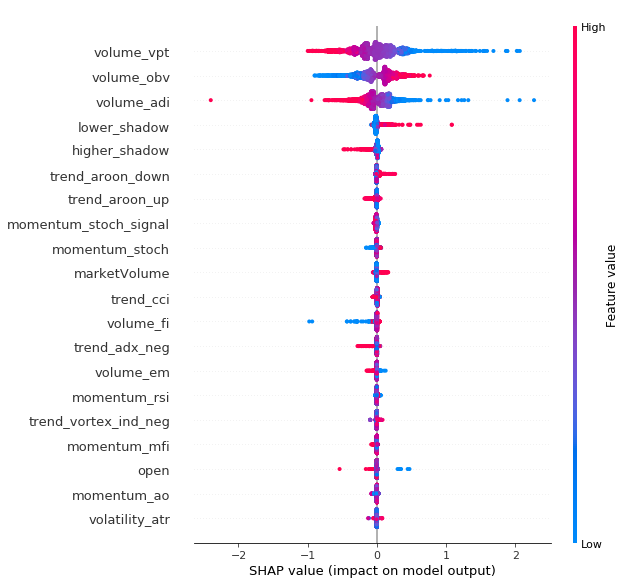

In [168]:
shap.summary_plot(shap_values, X)